# Quelles informations peut fournir notre téléphone selon notre déplacement ?

30 participants ont effectués des activités de la vie quotidienne tout en portant un smartphone à la ceinture. Le téléphone était configuré pour enregistrer les données de deux capteurs mis en place (accéléromètre et gyroscope). La jeu de données à été partitionné de façon aléatoire, où 70% des volontaires ont été sélectionner pour générer le train dataset et 30% pour le test ()


## Import Libraries

In [1]:
# Pour stocker les données
import pandas as pd

#Pour copier des variables
import copy

# Pour de l'algèbre linéaire
import numpy as np
from numpy import pi

# Pour créer des graphs
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

# Pour créer des meilleurs graphs
import seaborn as sns

# Pour créer des graphs interactif
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


from collections import Counter
from cycler import cycler
from scipy.stats import norm, skew, probplot
from scipy.optimize import curve_fit

# Pour construire des modeles
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

#Reseau de neuronne
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
import keras

# Pour gbm light
from lightgbm import LGBMClassifier

# Pour mesure de temps
from time import time

## Chargement des données

In [2]:
#Chargement du nom des colonnes et suppression des espaces
index_column = pd.read_csv('features.txt', header=None, sep="\n")
index_column = index_column.loc[:,0].str.strip()

In [3]:
# Chargement des données de train
trainX_df = pd.read_csv('Train/X_train.txt', sep=" ", header=None)
trainY_df = pd.read_csv('Train/y_train.txt', names={"id_label"}, header=None)

# Chargement des données de test
testX_df = pd.read_csv('Test/X_test.txt', sep=" ", header=None)
testY_df = pd.read_csv('Test/y_test.txt', names={"id_label"}, header=None)



In [4]:
# Insertion des noms des colonnes
trainX_df.columns = index_column.values
testX_df.columns = index_column.values

In [5]:
# Chargement des labels des activités
activity_label_df = pd.read_csv('activity_labels.txt', sep="\n", names={"activity"}, header=None)
activity_label_df['id_label'] = activity_label_df['activity'].str[0:2].astype('int64')
activity_label_df['activity'] = activity_label_df['activity'].str[2:]
activity_label_df['activity'] = activity_label_df['activity'].str.strip().astype('category')
activity_label_df

,activity,id_label
0,WALKING,1
1,WALKING_UPSTAIRS,2
2,WALKING_DOWNSTAIRS,3
3,SITTING,4
4,STANDING,5
5,LAYING,6
6,STAND_TO_SIT,7
7,SIT_TO_STAND,8
8,SIT_TO_LIE,9
9,LIE_TO_SIT,10


In [6]:
# Merge
trainY_df = pd.merge(trainY_df, activity_label_df, on='id_label', how='left', sort=False)
testY_df = pd.merge(testY_df, activity_label_df, on='id_label', how='left', sort=False)

trainY_df.head(20)

,id_label,activity
0,5,STANDING
1,5,STANDING
2,5,STANDING
3,5,STANDING
4,5,STANDING
5,5,STANDING
6,5,STANDING
7,5,STANDING
8,5,STANDING
9,5,STANDING


In [7]:
# Chargement du id des personnes ayant effectué les experiences
subjectTrain_df = pd.read_csv('Train/subject_id_train.txt', sep="\n", names={"subject"}, header=None)
subjectTest_df = pd.read_csv('Test/subject_id_test.txt', sep="\n", names={"subject"}, header=None)

In [8]:
trainX_df.head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-MeanFreq-1,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.012236,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.202804,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,0.440079,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,0.430891,-0.138373,-0.491604,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.137735,-0.366214,-0.702490,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080


In [9]:
train_df = copy.copy(trainX_df)
train_df['subject'] = subjectTrain_df['subject']
train_df['Activity'] = trainY_df['activity']


test_df = copy.copy(testX_df)
test_df['subject'] = subjectTest_df['subject']
test_df['Activity'] = testY_df['activity']


In [10]:
# Combine les deux jeux de données Train et Test en les identifiants
train_df['Data'] = 'Train'
test_df['Data'] = 'Test'
both_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
both_df['subject'] = '#' + both_df['subject'].astype(str)

# Creation des labels
label = both_df.pop('Activity')

print('Shape Train:\t{}'.format(trainX_df.shape))
print('Shape Test:\t{}\n'.format(testX_df.shape))

train_df.head()

Shape Train:	(7767, 561)
Shape Test:	(3162, 561)



,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,subject,Activity,Data
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,1,STANDING,Train
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,1,STANDING,Train
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,1,STANDING,Train
3,0.039785,-0.011809,-0.028916,-0.996194,-0.988569,-0.993256,-0.996994,-0.988526,-0.993135,-0.798477,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848947,0.181907,-0.040826,1,STANDING,Train
4,0.038758,-0.002289,-0.023863,-0.998241,-0.986774,-0.993115,-0.998216,-0.986479,-0.993825,-0.801982,...,0.123320,0.122542,0.693578,-0.615971,-0.848164,0.185124,-0.037080,1,STANDING,Train


D'après les informations du site, il y a 561 colonnes calculées et créées par les créateur du jeu de donnée à partir du temps et du domaine de fréquence.

Les caractéristiques sélectionnées pour cette base de données proviennent des signaux bruts triaxiaux de l'accéléromètre et du gyroscope. Ces signaux du domaine temporel (préfixe "t" pour indiquer le temps) ont été capturés à une fréquence constante de 50 Hz. Ils ont ensuite été filtrés à l'aide d'un filtre médian et d'un filtre passe-bas de Butterworth de 3e ordre avec une fréquence de coin de 20 Hz pour éliminer le bruit. De même, le signal d'accélération a ensuite été séparé en signaux d'accélération du corps et de la gravité (tBodyAcc-XYZ et tGravityAcc-XYZ) en utilisant un autre filtre de Butterworth passe-bas avec une fréquence de coin de 0,3 Hz. 

Par la suite, l'accélération linéaire du corps et la vitesse angulaire ont été dérivées dans le temps pour obtenir des signaux de secousse (tBodyAccJerk-XYZ et tBodyGyroJerk-XYZ). L'amplitude de ces signaux tridimensionnels a également été calculée en utilisant la norme euclidienne (tBodyAccMag, tGravityAccMag, tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag). 

Enfin, une transformation de Fourier rapide a été appliquée à certains de ces signaux, produisant fBodyAcc-XYZ, fBodyAccJerk-XYZ, fBodyGyro-XYZ, fBodyAccJerkMag, fBodyGyroMag, fBodyGyroJerkMag. (Notez le "f" pour indiquer les signaux du domaine des fréquences). 

(Infos issues du fichier features_info.txt, voir pour plus de détail)

## Dataset Exploration
### A quoi ressemble les features ?

In [11]:
trainX_df.dtypes

tBodyAcc-Mean-1                    float64
tBodyAcc-Mean-2                    float64
tBodyAcc-Mean-3                    float64
tBodyAcc-STD-1                     float64
tBodyAcc-STD-2                     float64
                                    ...   
tBodyGyro-AngleWRTGravity-1        float64
tBodyGyroJerk-AngleWRTGravity-1    float64
tXAxisAcc-AngleWRTGravity-1        float64
tYAxisAcc-AngleWRTGravity-1        float64
tZAxisAcc-AngleWRTGravity-1        float64
Length: 561, dtype: object

In [12]:
trainY_df.dtypes

id_label       int64
activity    category
dtype: object

In [13]:
# Get null values and dataframe information
print('Null Values In DataFrame: {}\n'.format(both_df.isna().sum().sum()))
both_df.info()

Null Values In DataFrame: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10929 entries, 0 to 10928
Columns: 563 entries, tBodyAcc-Mean-1 to Data
dtypes: float64(561), object(2)
memory usage: 46.9+ MB



### Comment les données sont distribuées ?

In [14]:
# Plotting data
label_counts = label.value_counts()

# Get colors
n = label_counts.shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Create plot
data = go.Bar(x = label_counts.index,
              y = label_counts,
              marker = dict(color = colors))

layout = go.Layout(title = 'Smartphone Activity Label Distribution',
                   xaxis = dict(title = 'Activity'),
                   yaxis = dict(title = 'Count'))

fig = go.Figure(data=[data], layout=layout)
iplot(fig)

Bien qu'il y ait des fluctuations dans le nombre d'étiquettes, les étiquettes sont réparties de manière assez égale.

### Pouvons nous différencier les activités ?

L'ensemble de données est destiné à classer l'activité du participant. Examinons la séparabilité des classes.

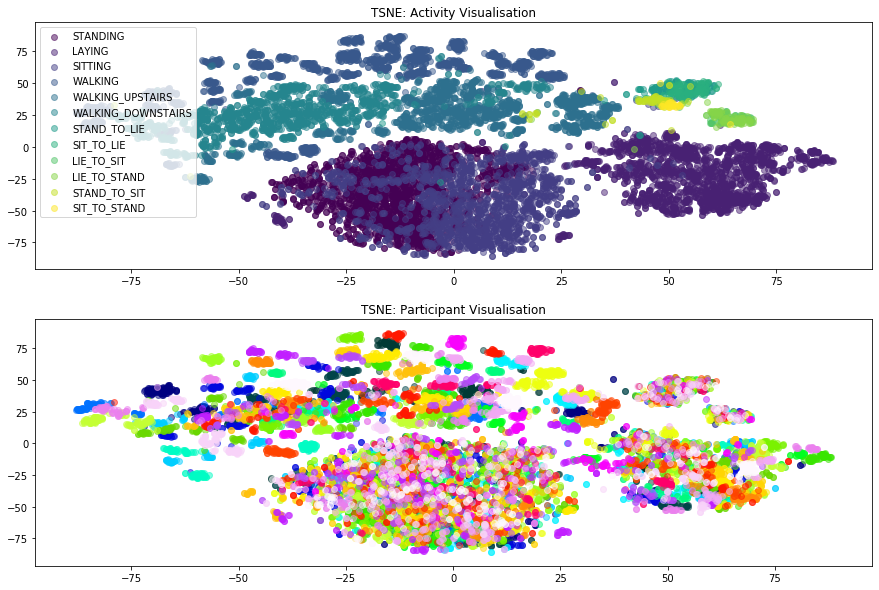

In [15]:
# Create datasets
tsne_data = both_df.copy()
data_data = tsne_data.pop('Data')
subject_data = tsne_data.pop('subject')

# Scale data
scl = StandardScaler()
tsne_data = scl.fit_transform(tsne_data)

# Reduce dimensions (speed up)
pca = PCA(n_components=0.9, random_state=3)
tsne_data = pca.fit_transform(tsne_data)

# Transform data
tsne = TSNE(random_state=3)
tsne_transformed = tsne.fit_transform(tsne_data)


# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(15,10))

### Plot Activities
# Get colors
n = label.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (label==group).values
    axarr[0].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject_data.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject_data.unique()):
    # Mask to separate sets
    mask = (subject_data==group).values
    axarr[1].scatter(x=tsne_transformed[mask][:,0], y=tsne_transformed[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()

Dans le graph 1, vous pouvez voir clairement que les activités sont pour la plupart séparables.

Le graph 2 révèle les informations personnelles des participants. Chacun a par exemple un style de marche unique et distinct (en haut à droite). Le smartphone doit donc être capable de détecter ce que vous faites et aussi qui utilise le smartphone (si vous vous déplacez avec lui).

### A quel point ces activités sont séparables ?

Essayons avec un simple SVM Claffisier en testant plusieurs C.

In [16]:
df = pd.DataFrame(columns=['C', 'Accuracy'])
accuracy = 0
for i in range(-5,5):
        print('Training linear svm... for C:{}'.format(2**i))
        lsvm_clf = svm.SVC(C=2**i, kernel='linear')
        lsvm_clf.fit(trainX_df,trainY_df['activity'])
        print('Done!')

        print('Calculating accuracy...')
        pred = lsvm_clf.predict(trainX_df)
        acc = np.sum(pred==trainY_df['activity'])/float(trainX_df.shape[0])
        print('Linear SVM Train Accuracy: %.4f' % acc)

        pred = lsvm_clf.predict(testX_df)
        accuracy = np.sum(pred==testY_df['activity'])/float(testX_df.shape[0])
        df = df.append({'C' : 2**i, 'Accuracy' : accuracy}, ignore_index=True)
        print('Linear SVM Validation Accuracy for C=%f: %.4f' % (2**i,accuracy))

Training linear svm... for C:0.03125
Done!
Calculating accuracy...
Linear SVM Train Accuracy: 0.9802
Linear SVM Validation Accuracy for C=0.031250: 0.9488
Training linear svm... for C:0.0625
Done!
Calculating accuracy...
Linear SVM Train Accuracy: 0.9849
Linear SVM Validation Accuracy for C=0.062500: 0.9488
Training linear svm... for C:0.125
Done!
Calculating accuracy...
Linear SVM Train Accuracy: 0.9879
Linear SVM Validation Accuracy for C=0.125000: 0.9494
Training linear svm... for C:0.25
Done!
Calculating accuracy...
Linear SVM Train Accuracy: 0.9911
Linear SVM Validation Accuracy for C=0.250000: 0.9532
Training linear svm... for C:0.5
Done!
Calculating accuracy...
Linear SVM Train Accuracy: 0.9928
Linear SVM Validation Accuracy for C=0.500000: 0.9526
Training linear svm... for C:1
Done!
Calculating accuracy...
Linear SVM Train Accuracy: 0.9930
Linear SVM Validation Accuracy for C=1.000000: 0.9519
Training linear svm... for C:2
Done!
Calculating accuracy...
Linear SVM Train Accuracy

Text(0.5, 1.0, 'Test Accuracy vs iteration number for C for linear SVM')

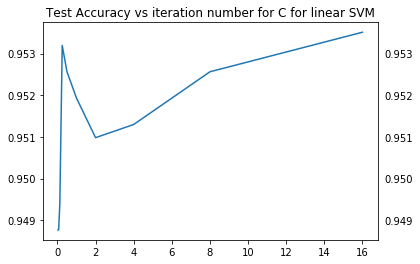

In [17]:
plt.figure()
plt.plot(df['C'], df['Accuracy'])
plt.tick_params(labelright = True)
plt.title('Test Accuracy vs iteration number for C for linear SVM')

In [18]:
df[df['Accuracy'] == max(df['Accuracy'])]

,C,Accuracy
9,16.0,0.95351


Sans effectué de feature engineering et de preprocessing poussé, on obtien un résulta très correct !
Comparons avec 2 autres modèles (RandomForest et LogisticRegression)

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

D:\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of itera

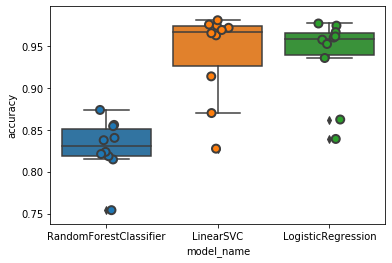

In [20]:
#Définition des modèles
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    LogisticRegression(random_state=0, multi_class='multinomial', max_iter=200),
]

#Nombre de cross validation
CV = 10

cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, trainX_df, trainY_df['activity'], scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [21]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.941046
LogisticRegression        0.938597
RandomForestClassifier    0.829416
Name: accuracy, dtype: float64

Parmis les 3 modèle, le LinearSVC a été meilleur.

Essayons les réseaux de neurone !

In [23]:
# Définition des couches du modèle
model = Sequential()
model.add(Dense(561, input_dim=561, activation='relu'))
model.add(Dense(250, activation='relu'))
model.add(Dense(125, activation='relu'))
model.add(Dense(60, activation='sigmoid'))
model.add(Dense(12, activation='softmax'))

In [24]:
# Compilation du modèle
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [25]:
y_train = keras.utils.to_categorical(trainY_df['id_label'] - 1, num_classes=12)
y_test = keras.utils.to_categorical(testY_df['id_label'] - 1, num_classes=12)


In [26]:
# Entrainement du reseau de neurone sur le dataset de train
history = model.fit(trainX_df, y_train, validation_data=(testX_df, y_test), epochs=150, batch_size=10)

=======================] - 2s 286us/step - loss: 0.1067 - accuracy: 0.9555 - val_loss: 0.2167 - val_accuracy: 0.9228
Epoch 17/150
7767/7767 [==============================] - 2s 286us/step - loss: 0.1206 - accuracy: 0.9521 - val_loss: 0.2129 - val_accuracy: 0.9159
Epoch 18/150
7767/7767 [==============================] - 2s 283us/step - loss: 0.1021 - accuracy: 0.9589 - val_loss: 0.2279 - val_accuracy: 0.9159
Epoch 19/150
7767/7767 [==============================] - 2s 282us/step - loss: 0.0918 - accuracy: 0.9609 - val_loss: 0.2162 - val_accuracy: 0.9279
Epoch 20/150
7767/7767 [==============================] - 2s 293us/step - loss: 0.1013 - accuracy: 0.9553 - val_loss: 0.1646 - val_accuracy: 0.9390
Epoch 21/150
7767/7767 [==============================] - 2s 285us/step - loss: 0.1047 - accuracy: 0.9569 - val_loss: 0.2553 - val_accuracy: 0.9162
Epoch 22/150
7767/7767 [==============================] - 2s 306us/step - loss: 0.0993 - accuracy: 0.9597 - val_loss: 0.2247 - val_accuracy: 0.

In [27]:
# Evaluation du modèle
_, train_acc = model.evaluate(trainX_df, y_train, verbose=0)
_, test_acc = model.evaluate(testX_df, y_test, verbose=0)
test_acc

0.9446552991867065

Train: 0.999, Test: 0.945


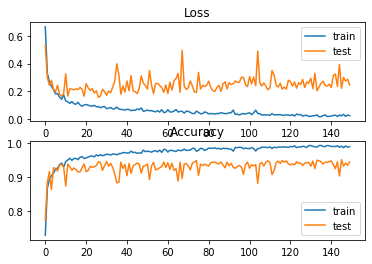

In [28]:
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot du loss pendant l'entrainement
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot de la précision pendant l'entrainement
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

Notre réseau de neurone à l'air d'avoir du mal à obtenir une meilleure précision en augmentant la durée de l'entrainement.

## Conclusion

Avec un modèle de base non réglé, l'activité de l'utilisateur de smartphone peut être prédite avec une précision de 95%.
Ce qui, on ne va pas se le cacher, un peu déroutant